In [1]:
%matplotlib inline 
import numpy as np
import pandas
import matplotlib.pyplot as plt

import sir
import inference

* [Bayesian model](#Bayesian-model)
* [Inference problem specification](#Inference-problem-specification)
* [Generate markov chain samples](#Generate-markov-chain-samples)

# Bayesian model

So that's cool, we can run the SIR model forward given parameters and get predictions depending on our scenario.

Now we want to use publically available data (deaths per day) to estimate those parameters from data.

We can create a bayesian hierarchical model for this:

* $deaths[i]$: observed variable, daily deaths, distributed depending on infection fatality rate and daily recoveries: $P(deaths[i] \mid \alpha, recovered[i])$
* $recovered(i, s_0, \beta_0, \beta_1, t\_lock, \gamma)$: recovered at day $i$, depends deterministically on our model
* $\alpha$ infection fatality rate
* $s_0$ SIR state for day 0
* $\beta_0$ SIR model beta for no-lockdown days
* $\beta_1$ SIR model beta for lockdown days
* $t\_lock$: point in time where lockdown measures are implemented
* $\gamma$ SIR model gamma, independent of lockdown


The distribution over the parameters is proportional to (assuming uniform priors over parameters to avoid writing their priors):

$$
P(\alpha, s_0, \beta_0, \beta_1, \gamma) \propto \prod_i{P(deaths[i] \mid \alpha, recovered(i, s_0, \beta_0, \beta_1, t\_lock, \gamma))}
$$

To calculate $P(deaths[i] \mid \alpha, recovered[i])$ we're going to use the [gaussian approximation to the binomial](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) and say the number of deaths per day follows this distribution, conditional on the number of recoveries per day and the infection fatality rate:

$$
deaths[i] \sim \mathcal{N}(recovered[i] \cdot \alpha, recovered[i]\cdot \alpha \cdot (1-\alpha)))
$$

## Inference problem specification

Let's load some data:

In [2]:
df = pandas.read_csv('new_deaths.csv')
deaths = np.array(df['Spain'])
dates = np.array(df['date'])

# lockdown starts 2020-03-05, find day index
t_lock = np.where(dates == '2020-03-05')[0][0]


To fully characterize an inference problem that will use this model, we need the following parameters:

In [3]:
spec = inference.Spec(
            population=46.66 * 1000000,
            deaths=deaths,
            b_infected=(1.0, 10000.0),
            b_alpha=(0.0001, 0.05),
            b_beta_0=(0.005, 0.8),
            b_beta_1=(0.005, 0.8),
            t_lock=t_lock,
            b_gamma=(1 / 30.0, 1 / 10.0),
            fuzz = 20.
        )

## Generate markov chain samples

We're ready to use our hideously inefficient mcmc sampler to sample from the posterior:

In [4]:
sampler = inference.MCMCSampler(spec)

for i in range(3000):
    sampler.step()

/Users/miguelsimon/armchair-covid19/inference.py:203: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(log_acceptance_ratio)


We should see the log probability rise after an initial burn in period:

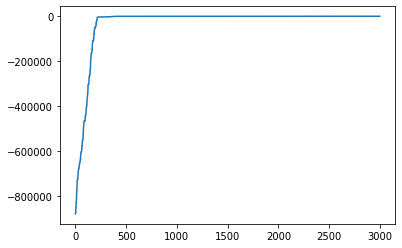

In [5]:
plt.plot(sampler.logps)
plt.show()


0.07663664176232154

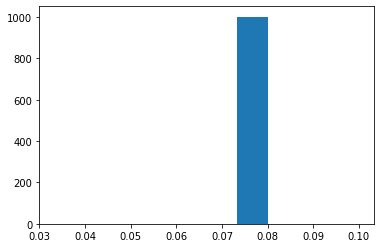

In [6]:
# discard first samples
samples = sampler.samples[2000:]

_ = plt.hist([s.gamma for s in samples], range = spec.b_gamma)
np.mean([s.gamma for s in samples])

5137.630353312687

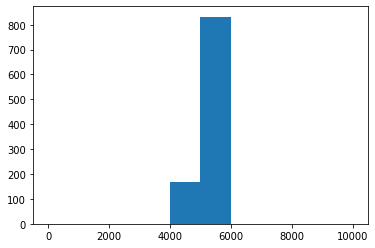

In [7]:
_ = plt.hist([s.infected for s in samples], range = spec.b_infected)
np.mean([s.infected for s in samples])

0.11602103500720524

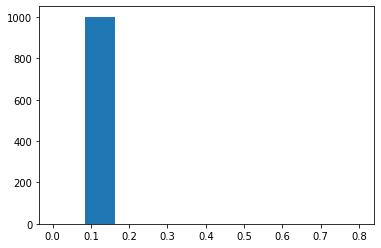

In [8]:
_ = plt.hist([s.beta_0 for s in samples], range = spec.b_beta_0)
np.mean([s.beta_0 for s in samples])

0.38845293770130745

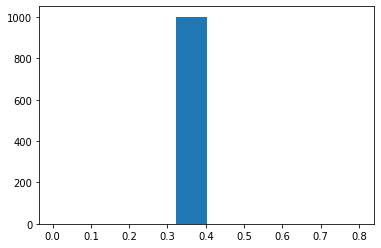

In [9]:
_ = plt.hist([s.beta_1 for s in samples], range = spec.b_beta_1)
np.mean([s.beta_1 for s in samples])

0.0005138048098993518

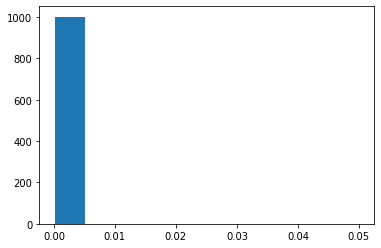

In [10]:
_ = plt.hist([s.alpha for s in samples], range = spec.b_alpha)
np.mean([s.alpha for s in samples])

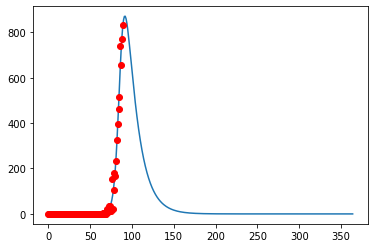

In [11]:
predict = inference.Predict(spec)
coord = samples[-1]
predicted_mean_deaths = predict.predict(coord)

plt.plot(np.arange(365), predicted_mean_deaths)
plt.plot(np.arange(len(deaths)), deaths, 'ro')